# Fuzzy sets

- Alfredo Vanegas Arcega: 297121

## Código de implementación

In [1]:
import matplotlib.pyplot as plt
import copy
import pandas as pd
from IPython.display import display
import scipy.integrate as integrate
import sympy as sy

### Código para formar Fuzzy Sets 

In [2]:
def get_equation_from_points(points):
    slope = (points[1][0]-points[1][1])/(points[0][0]-points[0][1])
    b = (slope * -points[0][0]) + (points[1][0])
    # 1 is a
    return (-1, slope, b)

In [3]:
def make_fuzzy_sets(nucleos, soportes, set_names):
    nucleos_y = [1 for x in nucleos]
    soportes_y = [0 for x in soportes]

    sets = []

    for i in range(0, len(nucleos), 2):
        x = list(nucleos[i:i+2])
        y = list(nucleos_y[i:i+2])

        left_right1_x = [nucleos[i], soportes[i]]
        left_right1_y = [nucleos_y[i], soportes_y[i]]

        left_right2_x = [soportes[i+1], nucleos[i+1]]
        left_right2_y = [soportes_y[i+1], nucleos_y[i+1]]

        sets.append({
            'nombre_set' : set_names[int(i/2)],
            'nucleos': [x,y],
            'nucleos_lr1': [left_right1_x,left_right1_y],
            'nucleos_lr2': [left_right2_x,left_right2_y]
        })

    return sets

In [4]:
def print_fuzzy_sets(sets, title='', set_colors=[]):
    fig, ax = plt.subplots() 
    ax.grid()
    fig.suptitle(title, fontsize=16)

    #ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))
    for set in sets:
        for key, values in set.items():
            if(key != 'nombre_set'):
                ax.plot(values[0], values[1], c=set_colors[set['nombre_set']])
    
    return (fig, ax)

In [5]:
def get_y_from_equation(equation, x):
    y = (equation[1] * x) + equation[2]
    return round(y, 4)

In [6]:
def get_x_from_equation(equation, y):
    x = (y - equation[2]) / equation[1]
    return x

In [7]:
def find_set_in_list(list, set_name):
    for set_ in list:
        if(set_['nombre_set'] == set_name):
            return set_
    return {}

In [8]:
def mamdani_method(sets, soportes, nucleos, value, set_names):
    # We need to find where the value fits, for that, we iterate over
    # the supports like a range to find the set that belongs to
    value_in_sets = []
    for i in range(0, len(soportes), 2):
        if(soportes[i] <= value & value <= soportes[i+1]):
            set_name = set_names[int(i/2)]
            # Check if value exists in the lr1 line
            if(soportes[i] <= value & value <= nucleos[i]):
                set_ = find_set_in_list(sets, set_name)
                equation = get_equation_from_points(set_['nucleos_lr1'])
                location = [value, get_y_from_equation(equation, value)]
                supports = [soportes[i], soportes[i+1]]
                nuclei = [nucleos[i], nucleos[i+1]]
            elif(nucleos[i] <= value & value <= nucleos[i+1]):
                set_ = find_set_in_list(sets, set_name)
                equation = get_equation_from_points(set_['nucleos'])
                location = [value, get_y_from_equation(equation, value)]
                supports = [soportes[i], soportes[i+1]]
                nuclei = [nucleos[i], nucleos[i+1]]
            else:
                set_ = find_set_in_list(sets, set_name)
                equation = get_equation_from_points(set_['nucleos_lr2'])
                location = [value, get_y_from_equation(equation, value)]
                supports = [soportes[i], soportes[i+1]]
                nuclei = [nucleos[i], nucleos[i+1]]

            value_in_sets.append({
                'set_name': set_name,
                'location': location,
                'equation': equation,
                'supports': supports,
                'nuclei': nuclei,
            })
    return value_in_sets

In [9]:
def print_mamdani_lines(fig, ax, pertinence_set):
    for segment in pertinence_set:
        p_values = segment['location']
        x = p_values[0]
        y = p_values[1]
        ax.scatter(x, y, c="red",marker='o')

        vertical_x = [x, x]
        vertical_y = [0, 1]
        ax.plot(vertical_x, vertical_y, c="blue", linestyle='--', linewidth=1)

        horizontal_x = [0, x]
        horizontal_y = [y, y]
        ax.plot(horizontal_x, horizontal_y, c="blue", linestyle='--', linewidth=1)

    return (fig, ax)

In [10]:
def get_lowest_pvalue(sets):
    lowest_pvalue = 2
    lowest_set = {}
    for set_ in sets:
        set_pvalue = set_['location'][1]
        if(set_pvalue != 0 and set_pvalue < lowest_pvalue):
            lowest_pvalue = set_pvalue
            lowest_set = set_
    return lowest_set

In [11]:
def max_min_inference(input_sets, output_name, ouptut_sets):
    lowest_set = get_lowest_pvalue(input_sets) 
    output_set = copy.deepcopy(find_set_in_list(ouptut_sets, output_name))
    output_y = lowest_set['location'][1]
    output_x1 = get_x_from_equation(get_equation_from_points(output_set['nucleos_lr1']), output_y)
    output_x2 = get_x_from_equation(get_equation_from_points(output_set['nucleos_lr2']), output_y)
    
    output_set['nucleos'][1] = [output_y, output_y]
    output_set['nucleos'][0] = [output_x2, output_x1]

    output_set['nucleos_lr1'][1][0] = output_y
    output_set['nucleos_lr2'][1][1] = output_y

    output_set['nucleos_lr1'][0][0] = output_x1
    output_set['nucleos_lr2'][0][1] = output_x2

    return output_set

## Fuzzy sets

In [12]:
expert_knowledge = pd.read_csv('./sistema_experto.csv')
expert_knowledge = expert_knowledge.set_index('Cantidad')
expert_knowledge

,Baja,Regular,Alta,Muy Alta
Cantidad,,,,
Pocos,A,A,B,B
Normal,A,C,C,C
Muchos,B,C,D,D


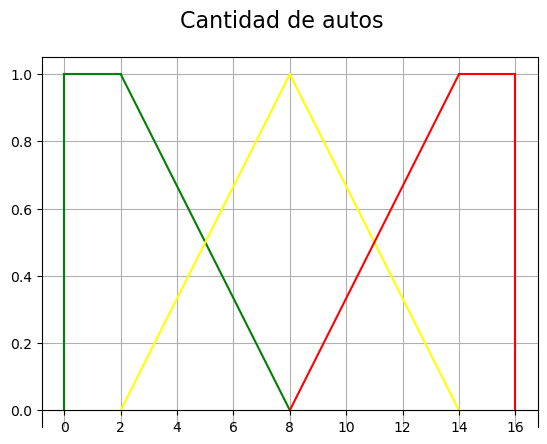

In [13]:
nucleos = [0,2,8,8,14,16]
soportes = [0,8,2,14,8,16]
set_names = ['Pocos', 'Normal', 'Muchos']
set_colors = {'Pocos': 'green', 'Normal': 'yellow', 'Muchos':'red'}
can_set = make_fuzzy_sets(nucleos, soportes, set_names)
can_set_fig, can_set_ax = print_fuzzy_sets(can_set, 'Cantidad de autos', set_colors)

Valores de pertinencia : [{'set_name': 'Pocos', 'location': [8, 0.0], 'equation': (-1, -0.16666666666666666, 1.3333333333333333), 'supports': [0, 8], 'nuclei': [0, 2]}, {'set_name': 'Normal', 'location': [8, 1.0], 'equation': (-1, 0.16666666666666666, -0.33333333333333326), 'supports': [2, 14], 'nuclei': [8, 8]}, {'set_name': 'Muchos', 'location': [8, 0.0], 'equation': (-1, 0.16666666666666666, -1.333333333333333), 'supports': [8, 16], 'nuclei': [14, 16]}]
Valor de pertinencia más bajo {'set_name': 'Normal', 'location': [8, 1.0], 'equation': (-1, 0.16666666666666666, -0.33333333333333326), 'supports': [2, 14], 'nuclei': [8, 8]}


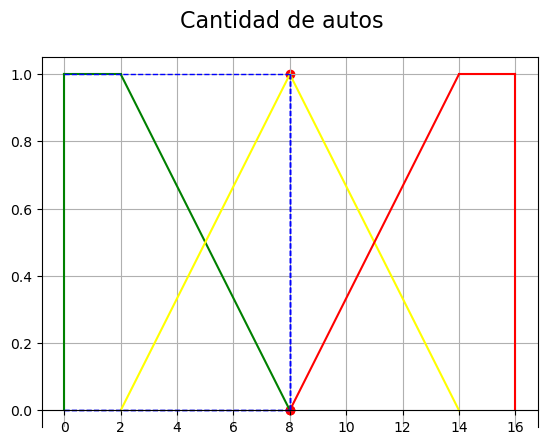

In [14]:
can_value = 8
can_pertinence_values = mamdani_method(can_set, soportes, nucleos, can_value, set_names)
can_lowest_pvalue = get_lowest_pvalue(can_pertinence_values)
print("Valores de pertinencia :",can_pertinence_values)
print("Valor de pertinencia más bajo", can_lowest_pvalue)
can_set_fig, can_set_ax = print_mamdani_lines(can_set_fig, can_set_ax, can_pertinence_values)
can_set_fig

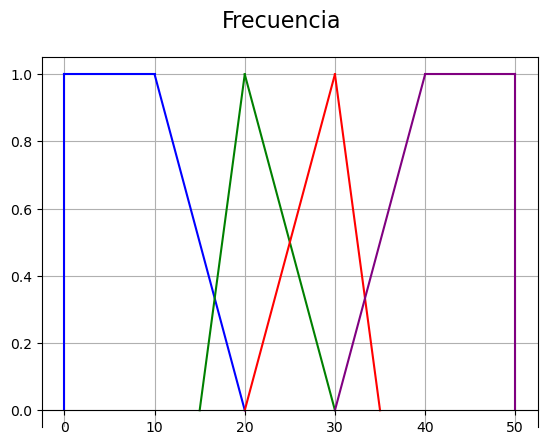

In [15]:
nucleos = [0,10,20,20,30,30,40,50]
soportes = [0,20,15,30,20,35,30,50]
set_names = ['Baja', 'Normal', 'Alta', 'Muy Alta']
set_colors = {'Baja': 'blue', 'Normal': 'green', 'Alta':'red', 'Muy Alta': 'purple'}
fre_set = make_fuzzy_sets(nucleos, soportes, set_names)
fre_set_fig, fre_set_ax = print_fuzzy_sets(fre_set, 'Frecuencia', set_colors)

Valores de pertinencia : [{'set_name': 'Baja', 'location': [15, 0.5], 'equation': (-1, -0.1, 2.0), 'supports': [0, 20], 'nuclei': [0, 10]}, {'set_name': 'Normal', 'location': [15, 0.0], 'equation': (-1, 0.2, -3.0), 'supports': [15, 30], 'nuclei': [20, 20]}]
Valor de pertinencia más bajo {'set_name': 'Baja', 'location': [15, 0.5], 'equation': (-1, -0.1, 2.0), 'supports': [0, 20], 'nuclei': [0, 10]}


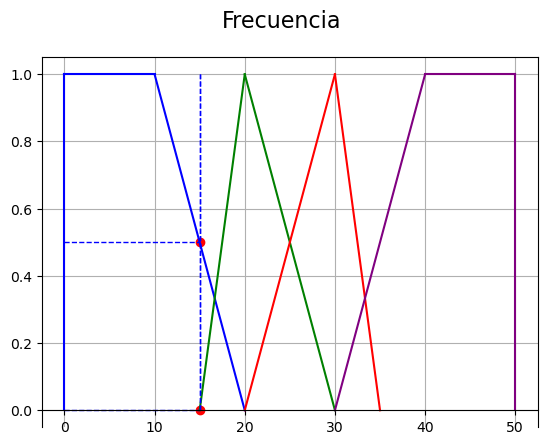

In [16]:
fre_value = 15  
fre_pertinence_values = mamdani_method(fre_set, soportes, nucleos, fre_value, set_names)
fre_lowest_pvalue = get_lowest_pvalue(fre_pertinence_values)
print("Valores de pertinencia :", fre_pertinence_values)
print("Valor de pertinencia más bajo", fre_lowest_pvalue)
fre_set_fig, fre_set_ax = print_mamdani_lines(fre_set_fig, fre_set_ax, fre_pertinence_values)
fre_set_fig

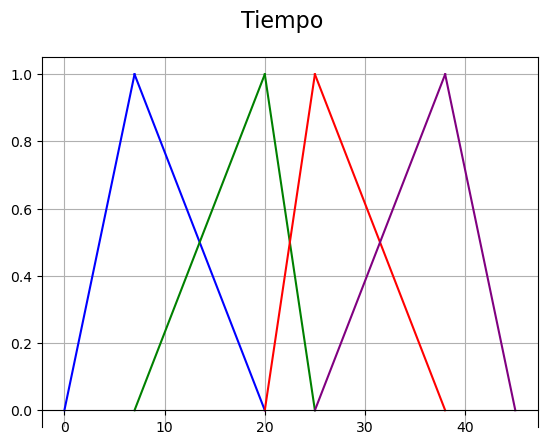

In [17]:
nucleos = [7,7,20,20,25,25,38,38]
soportes = [0,20,7,25,20,38,25,45]
set_names = ['A', 'B', 'C', 'D']
set_colors = {'A': 'blue', 'B': 'green', 'C':'red', 'D': 'purple'}
temp_set = make_fuzzy_sets(nucleos, soportes, set_names)
temp_set_fig, temp_set_ax = print_fuzzy_sets(temp_set, 'Tiempo', set_colors)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

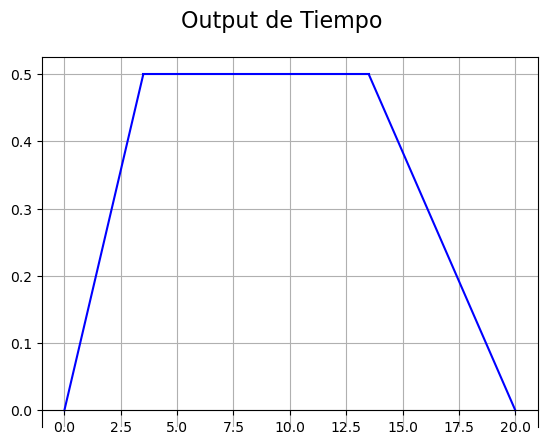

In [18]:
fre_set_name = fre_lowest_pvalue['set_name']
can_set_name = can_lowest_pvalue['set_name']
output_name = expert_knowledge[fre_set_name][can_set_name]
input_sets = [can_lowest_pvalue, fre_lowest_pvalue]
max_min_output = max_min_inference(input_sets, output_name, temp_set)
print_fuzzy_sets([max_min_output], 'Output de Tiempo', set_colors)

In [19]:
def defuzz_cog(agg_sets):
    denominator = 0
    numerator = 0
    x = sy.Symbol('x')
    for key in agg_sets:
        if(key != 'nombre_set'):
            line_eq = get_equation_from_points(agg_sets[key])
            r = agg_sets[key][0]
            num_result = sy.integrate((line_eq[1]*x + line_eq[2]) * x , (x, r[1], r[0]))
            den_result = sy.integrate((line_eq[1]*x + line_eq[2]) , (x, r[1], r[0]))
            numerator += (num_result)
            denominator += (den_result)
    return numerator / denominator

print('Valor desfuzzificado (CoG): ', defuzz_cog(max_min_output))

Valor desfuzzificado (CoG):  9.33333333333334
